# SETUP

In [1]:
import pandas as pd
import numpy as np

%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

import datetime as dt

import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func, desc

### Use SQLAlchemy create_engine to connect to your sqlite database.

In [2]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite", echo=False)

### Inspect database

In [3]:
inspector = inspect(engine)
tables = inspector.get_table_names()

In [4]:
for table in tables:
    print("\n=========")
    print(table)
    print("-----")
    columns = inspector.get_columns(table)
    for c in columns:
        print(c['name'], c["type"])


measurement
-----
id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT

station
-----
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


### Use SQLAlchemy automap_base() to reflect your tables into classes and save a reference to those classes called Station and Measurement.

In [5]:
Base = automap_base()
Base.prepare(engine, reflect=True)
Measurement = Base.classes.measurement
Station = Base.classes.station
session = Session(engine)

# Precipitation Analysis

### Design a query to retrieve the last 12 months of precipitation data.

In [6]:
ts = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
ts

('2017-08-23')

In [7]:
most_recent = dt.datetime.strptime(ts[0],'%Y-%m-%d').date()
year_previous = most_recent - dt.timedelta(365)
year_previous
year_previous.strftime('%Y-%m-%d')

'2016-08-23'

### Select only the date and prcp values.

In [8]:
precip_data = session.query(Measurement.date, Measurement.prcp).\
                    filter(Measurement.date >= year_previous).\
                    order_by(Measurement.date).\
                    all()
precip_data

[('2016-08-23', 0.0),
 ('2016-08-23', 0.15),
 ('2016-08-23', 0.05),
 ('2016-08-23', None),
 ('2016-08-23', 0.02),
 ('2016-08-23', 1.79),
 ('2016-08-23', 0.7),
 ('2016-08-24', 0.08),
 ('2016-08-24', 2.15),
 ('2016-08-24', 2.28),
 ('2016-08-24', None),
 ('2016-08-24', 1.22),
 ('2016-08-24', 2.15),
 ('2016-08-24', 1.45),
 ('2016-08-25', 0.08),
 ('2016-08-25', 0.08),
 ('2016-08-25', 0.0),
 ('2016-08-25', 0.0),
 ('2016-08-25', 0.21),
 ('2016-08-25', 0.06),
 ('2016-08-25', 0.11),
 ('2016-08-26', 0.0),
 ('2016-08-26', 0.03),
 ('2016-08-26', 0.02),
 ('2016-08-26', 0.04),
 ('2016-08-26', 0.0),
 ('2016-08-26', 0.01),
 ('2016-08-27', 0.0),
 ('2016-08-27', 0.18),
 ('2016-08-27', 0.02),
 ('2016-08-27', 0.0),
 ('2016-08-27', 0.12),
 ('2016-08-27', None),
 ('2016-08-28', 0.01),
 ('2016-08-28', 0.14),
 ('2016-08-28', 0.14),
 ('2016-08-28', 0.14),
 ('2016-08-28', 0.6),
 ('2016-08-28', 2.07),
 ('2016-08-29', 0.0),
 ('2016-08-29', 0.17),
 ('2016-08-29', 0.04),
 ('2016-08-29', None),
 ('2016-08-29', 0.0),

### Load the query results into a Pandas DataFrame and set the index to the date column.

In [9]:
precip_df = pd.DataFrame(precip_data)
precip_df.rename(columns={'prcp':'precipitation'}, inplace=True)
precip_df.set_index('date')

,precipitation
date,
2016-08-23,0.00
2016-08-23,0.15
2016-08-23,0.05
2016-08-23,NaN
2016-08-23,0.02
...,...
2017-08-22,0.50
2017-08-23,0.00
2017-08-23,0.00


### Sort the DataFrame values by date.
This step is unecessary, because the query results were sorted, but it's a listed requirement, so...

In [10]:
precip_df.sort_index(inplace=True)
precip_df

,date,precipitation
0,2016-08-23,0.00
1,2016-08-23,0.15
2,2016-08-23,0.05
3,2016-08-23,NaN
4,2016-08-23,0.02
...,...,...
2225,2017-08-22,0.50
2226,2017-08-23,0.00
2227,2017-08-23,0.00
2228,2017-08-23,0.08


### Plot the results using the DataFrame plot method.

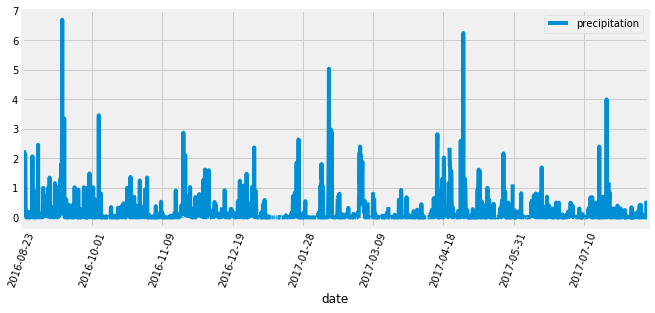

In [11]:
precip_plot = precip_df.plot(x='date', figsize=(10,4), grid=True, rot=70)
precip_plot

### Use Pandas to print the summary statistics for the precipitation data.

In [12]:
precip_df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Station Analysis

### Design a query to calculate the total number of stations.

In [13]:
session.query(Station).count()

9

### Design a query to find the most active stations.
#### List the stations and observation counts in descending order.

In [14]:
obs_data = session.query(Measurement.station, func.count(Measurement.tobs).label('total_observations')).\
            group_by(Measurement.station).\
            order_by(desc('total_observations')).\
            all()
obs_data

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

#### Which station has the highest number of observations?

In [15]:
obs_data[0]

('USC00519281', 2772)

### Design a query to retrieve the last 12 months of temperature observation data (tobs).
#### Filter by the station with the highest number of observations.

In [16]:
station = obs_data[0][0]
tobs_data = session.query(Measurement.date, Measurement.tobs).\
                    filter(Measurement.date >= year_previous, Measurement.station == station).\
                    order_by(Measurement.date).\
                    all()
tobs_data

[('2016-08-23', 77.0),
 ('2016-08-24', 77.0),
 ('2016-08-25', 80.0),
 ('2016-08-26', 80.0),
 ('2016-08-27', 75.0),
 ('2016-08-28', 73.0),
 ('2016-08-29', 78.0),
 ('2016-08-30', 77.0),
 ('2016-08-31', 78.0),
 ('2016-09-01', 80.0),
 ('2016-09-02', 80.0),
 ('2016-09-03', 78.0),
 ('2016-09-04', 78.0),
 ('2016-09-05', 78.0),
 ('2016-09-06', 73.0),
 ('2016-09-07', 74.0),
 ('2016-09-08', 80.0),
 ('2016-09-09', 79.0),
 ('2016-09-10', 77.0),
 ('2016-09-11', 80.0),
 ('2016-09-12', 76.0),
 ('2016-09-13', 79.0),
 ('2016-09-14', 75.0),
 ('2016-09-15', 79.0),
 ('2016-09-16', 78.0),
 ('2016-09-17', 79.0),
 ('2016-09-18', 78.0),
 ('2016-09-19', 78.0),
 ('2016-09-20', 76.0),
 ('2016-09-21', 74.0),
 ('2016-09-22', 77.0),
 ('2016-09-23', 78.0),
 ('2016-09-24', 79.0),
 ('2016-09-25', 79.0),
 ('2016-09-26', 77.0),
 ('2016-09-27', 80.0),
 ('2016-09-28', 78.0),
 ('2016-09-29', 78.0),
 ('2016-09-30', 78.0),
 ('2016-10-01', 77.0),
 ('2016-10-02', 79.0),
 ('2016-10-03', 79.0),
 ('2016-10-04', 79.0),
 ('2016-10-

In [17]:
tobs_df = pd.DataFrame(tobs_data)
tobs_df.set_index('date')
tobs_df

,date,tobs
0,2016-08-23,77.0
1,2016-08-24,77.0
2,2016-08-25,80.0
3,2016-08-26,80.0
4,2016-08-27,75.0
...,...,...
347,2017-08-14,77.0
348,2017-08-15,77.0
349,2017-08-16,76.0
350,2017-08-17,76.0


#### Plot the results as a histogram with bins=12.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001D572405D48>]],
      dtype=object)

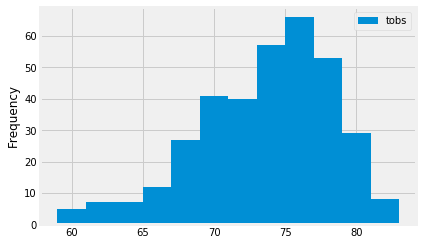

In [18]:
tobs_plot = tobs_df.hist(column='tobs', grid=True, figsize=(6,4), bins=12)
ax = tobs_plot[0][0]
ax.set_title("")
ax.set_ylabel("Frequency")
ax.legend(["tobs"])
tobs_plot